In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [16]:
#loeme andmed sisse
data_orig=pd.read_csv("soidukid.csv",on_bad_lines='skip', sep=";")

C:\Users\Liis Reimand\AppData\Local\Temp\ipykernel_15816\1789013292.py:2: DtypeWarning: Columns (8,9,21) have mixed types. Specify dtype option on import or set low_memory=False.
  data_orig=pd.read_csv("soidukid.csv",on_bad_lines='skip', sep=";")


In [17]:
#kopeerime originaalse andmestiku
data=data_orig.copy()
data.head()

,Andmed seisuga,YLDINE_STAATUS,EESTIS_ESMAREG_KP,ESMANE_REG_KP,KAIGUKASTI_TYYP,Kütuse tüüp,MOOTORI_TYYP,MOOTORI_MAHT,MOOTORI_VOIMSUS,HYBRIIDI_TYYP,...,REG_MASS,TAISMASS,TYHIMASS,TELGI_KOKKU,HEITMENORM,VARV,ISTEKOHTI,Kere nimetus,VK/OM MAAKOND,ARV
0,01.12.2022,PEATATUD,01.01.0987,01.01.1987,NaN,BENSIIN,BENSIIN,1452.0,55.0,NaN,...,1510,1510.0,1050.0,2.0,NaN,BEEZ,5,UNIVERSAAL,PÕLVA MAAKOND,1
1,01.12.2022,PEATATUD,30.12.1899,01.01.1987,NaN,DIISEL,DIISEL,1608.0,40.0,NaN,...,1350,1350.0,910.0,2.0,NaN,BEEZ,5,LUUKPÄRA,HARJU MAAKOND,1
2,01.12.2022,PEATATUD,01.01.1900,01.01.1939,NaN,BENSIIN,BENSIIN,690.0,15.0,NaN,...,1120,1120.0,750.0,2.0,NaN,MUST,4,KUPEE,HARJU MAAKOND,1
3,01.12.2022,PEATATUD,01.01.1900,01.01.1939,NaN,BENSIIN,BENSIIN,2120.0,58.0,NaN,...,2020,2020.0,1430.0,2.0,NaN,HALL,5,SEDAAN,TARTU MAAKOND,1
4,01.12.2022,PEATATUD,01.01.1900,01.01.1948,MANUAAL,BENSIIN,BENSIIN,2445.0,52.0,NaN,...,1550,1550.0,1050.0,2.0,NaN,ROHELINE,5,LUUKPÄRA,SAARE MAAKOND,1


In [18]:
#kustutame ebavajalikud andmed
data=data[data.YLDINE_STAATUS != "PEATATUD"]
data=data.reset_index()
data=data.drop(["Andmed seisuga","index","VARV","ISTEKOHTI", "Kere nimetus", "ARV","Kategooria","Keretüüp","TELGI_KOKKU","TAISMASS", "TYHIMASS","YLDINE_STAATUS","EESTIS_ESMAREG_KP", "MOOTORI_TYYP", "Kütuse tüüp", "HYBRIIDI_TYYP"], axis=1)

In [19]:
#asendame Nan-informatsioonilahtrid käigukastitüübis
#Nan -> manuaal
data["KAIGUKASTI_TYYP"]=data["KAIGUKASTI_TYYP"].fillna("MANUAAL")

In [20]:
#asendame puuduvad NEDC väärtused võimalusel WLTP omadega, vastasel juhul
#eelistame NEDC

for i in range(len(data["CO2_NEDC"])):
    vana=data["CO2_NEDC"].iloc[i]
    uus=data["CO2_WLTP"].iloc[i]
    if str(vana)=="nan" and str(uus)!="nan":
        data.loc[i,'CO2_NEDC']=int(uus)
data=data.drop(["CO2_WLTP"], axis=1)        

In [21]:
#data.to_csv('soidukid_cleaned.csv',encoding='utf-8-sig',sep=';')

In [22]:
#VAZ-de CO2_NEDC NaN väärtused asendame 210-ga, kuna antud autod omavad sama mootorit
for i in range(len(data["CO2_NEDC"])):
    mark=data["Mark"].iloc[i]
    if str(mark)=="VAZ":
        data.loc[i,'CO2_NEDC']=210

In [24]:
#Peamised mootorid ning nende CO2_NEDC, et vähendada NaN valuesid CO2 tulbas
motoras_VW={1968.0:146.0, 1896.0:162.0, 2461.0:171.0, 2771.0:255.0, 2967.0:180.0 ,1781.0:190.0, 2792.0:278.0}
motoras_BMW={1596.0:171.6, 1991.0:165.3, 2979.0:169.0, 2993.0:170.0, 2926.0:178.0, 1995.0:153.0, 1796.0:208.0, 1950.0:158.0}

In [25]:
#Asendame NaN-valued võimalusel Volkswageni ja Audi peamiste mootorite CO2 reostustasemed
for i in range(len(data["CO2_NEDC"])):
    mootor=data["MOOTORI_MAHT"].iloc[i]
    NEDC=data["CO2_NEDC"].iloc[i]
    mark=data["Mark"].iloc[i]
    if str(NEDC)=="nan" and float(mootor) in motoras_VW.keys() and (str(mark)=="VOLKSWAGEN" or str(mark)=="AUDI"):
        data.loc[i,'CO2_NEDC']=int(motoras_VW.get(float(mootor)))

In [26]:
#Asendame NaN-valued võimalusel BMW peamiste mootorite CO2 reostustasemed
for i in range(len(data["CO2_NEDC"])):
    mootor=data["MOOTORI_MAHT"].iloc[i]
    NEDC=data["CO2_NEDC"].iloc[i]
    mark=data["Mark"].iloc[i]
    if str(NEDC)=="nan" and float(mootor) in motoras_BMW.keys() and str(mark)=="BMW":
        data.loc[i,'CO2_NEDC']=int(motoras_BMW.get(float(mootor)))

In [27]:
#Asendame NaN-valued elektri-autodel nulliga
for i in range(len(data["CO2_NEDC"])):
    kütus=data["Kütusekombinatsioon"].iloc[i]
    NEDC=data["CO2_NEDC"].iloc[i]
    if str(NEDC)=="nan" and str(kütus)=="ELEKTER":
        data.loc[i,'CO2_NEDC']=0

In [28]:
brändid={}
for i in range(len(data["CO2_NEDC"])):
    NEDC=data["CO2_NEDC"].iloc[i]
    if str(NEDC)=="nan":
        if str(data["Mark"].iloc[i]) in brändid.keys():
            brändid[str(data["Mark"].iloc[i])]= int(brändid.get(str(data["Mark"].iloc[i])))+1
        else:
            brändid[str(data["Mark"].iloc[i])]= 1             
brändid=dict(sorted(brändid.items(), key=lambda item: item[1]))
#print(brändid)

In [29]:
#Asendame vigased maakonna nimed
tundmatud=['L��NE-VIRU MAAKOND', 'P�RNU MAAKOND', 'J�RVA MAAKOND', 'P�LVA MAAKOND', 'V�RU MAAKOND']
asendused=["LÄÄNE-VIRU MAAKOND", "PÄRNU MAAKOND", "JÄRVA MAAKOND", "PÕLVA MAAKOND", "VÕRU MAAKOND"]

for i in range(len(tundmatud)):
    data["VK/OM MAAKOND"]=data["VK/OM MAAKOND"].replace([tundmatud[i]],asendused[i])
    
MAAKONNAD=[]
for i in range(len(data["VK/OM MAAKOND"])):
    maakond=data["VK/OM MAAKOND"].iloc[i]
    if str(maakond) not in MAAKONNAD:
        MAAKONNAD.append(str(maakond))

In [30]:
autod_maakonnas={'HARJU MAAKOND':0, 'PÄRNU MAAKOND':0, 'TARTU MAAKOND':0, 'VALGA MAAKOND':0, 'VÕRU MAAKOND':0, 'HIIU MAAKOND':0, 'PÕLVA MAAKOND':0, 'SAARE MAAKOND':0, 'LÄÄNE-VIRU MAAKOND':0, 'IDA-VIRU MAAKOND':0, 'JÕGEVA MAAKOND':0, 'LÄÄNE MAAKOND':0, 'RAPLA MAAKOND':0, 'VILJANDI MAAKOND':0, 'JÄRVA MAAKOND':0, 'MÄÄRAMATA':0}
passatid_maakonnas={'HARJU MAAKOND':0, 'PÄRNU MAAKOND':0, 'TARTU MAAKOND':0, 'VALGA MAAKOND':0, 'VÕRU MAAKOND':0, 'HIIU MAAKOND':0, 'PÕLVA MAAKOND':0, 'SAARE MAAKOND':0, 'LÄÄNE-VIRU MAAKOND':0, 'IDA-VIRU MAAKOND':0, 'JÕGEVA MAAKOND':0, 'LÄÄNE MAAKOND':0, 'RAPLA MAAKOND':0, 'VILJANDI MAAKOND':0, 'JÄRVA MAAKOND':0, 'MÄÄRAMATA':0}
passatid_kokku=0

#Loeme maakondades kõik autod ja passatid kokku ning lisame vastavalt sõnastikesse
for i in range(len(data["VK/OM MAAKOND"])):
    mudel=data["Mudel"].iloc[i]
    maakond=data["VK/OM MAAKOND"].iloc[i]
    autod_maakonnas[str(maakond)]= int(autod_maakonnas.get(str(maakond)))+1
    if "PASSAT" in str(mudel):
        passatid_kokku+=1
        passatid_maakonnas[str(maakond)]= int(passatid_maakonnas.get(str(maakond)))+1

print("Passateid Eestis " + str(passatid_kokku))
print(autod_maakonnas)
print(passatid_maakonnas)

Passateid Eestis 29261
{'HARJU MAAKOND': 281403, 'PÄRNU MAAKOND': 42387, 'TARTU MAAKOND': 74682, 'VALGA MAAKOND': 14754, 'VÕRU MAAKOND': 20159, 'HIIU MAAKOND': 6339, 'PÕLVA MAAKOND': 15091, 'SAARE MAAKOND': 20174, 'LÄÄNE-VIRU MAAKOND': 29375, 'IDA-VIRU MAAKOND': 48605, 'JÕGEVA MAAKOND': 14729, 'LÄÄNE MAAKOND': 10963, 'RAPLA MAAKOND': 18914, 'VILJANDI MAAKOND': 24343, 'JÄRVA MAAKOND': 15828, 'MÄÄRAMATA': 11487}
{'HARJU MAAKOND': 8835, 'PÄRNU MAAKOND': 2027, 'TARTU MAAKOND': 4346, 'VALGA MAAKOND': 1055, 'VÕRU MAAKOND': 1833, 'HIIU MAAKOND': 276, 'PÕLVA MAAKOND': 1419, 'SAARE MAAKOND': 816, 'LÄÄNE-VIRU MAAKOND': 1317, 'IDA-VIRU MAAKOND': 2101, 'JÕGEVA MAAKOND': 995, 'LÄÄNE MAAKOND': 479, 'RAPLA MAAKOND': 876, 'VILJANDI MAAKOND': 1462, 'JÄRVA MAAKOND': 830, 'MÄÄRAMATA': 594}


In [31]:
for i in range(len(autod_maakonnas)):
    print("Passateid " + str(MAAKONNAD[i]) +" "+ str(round((passatid_maakonnas.get(MAAKONNAD[i])/autod_maakonnas.get(MAAKONNAD[i]))*100,2))+ " %")

Passateid HARJU MAAKOND 3.14 %
Passateid PÄRNU MAAKOND 4.78 %
Passateid TARTU MAAKOND 5.82 %
Passateid VALGA MAAKOND 7.15 %
Passateid VÕRU MAAKOND 9.09 %
Passateid HIIU MAAKOND 4.35 %
Passateid PÕLVA MAAKOND 9.4 %
Passateid SAARE MAAKOND 4.04 %
Passateid LÄÄNE-VIRU MAAKOND 4.48 %
Passateid IDA-VIRU MAAKOND 4.32 %
Passateid JÕGEVA MAAKOND 6.76 %
Passateid LÄÄNE MAAKOND 4.37 %
Passateid RAPLA MAAKOND 4.63 %
Passateid VILJANDI MAAKOND 6.01 %
Passateid JÄRVA MAAKOND 5.24 %
Passateid MÄÄRAMATA 5.17 %


In [32]:
CO2_maakonnas={'HARJU MAAKOND':0, 'PÄRNU MAAKOND':0, 'TARTU MAAKOND':0, 'VALGA MAAKOND':0, 'VÕRU MAAKOND':0, 'HIIU MAAKOND':0, 'PÕLVA MAAKOND':0, 'SAARE MAAKOND':0, 'LÄÄNE-VIRU MAAKOND':0, 'IDA-VIRU MAAKOND':0, 'JÕGEVA MAAKOND':0, 'LÄÄNE MAAKOND':0, 'RAPLA MAAKOND':0, 'VILJANDI MAAKOND':0, 'JÄRVA MAAKOND':0, 'MÄÄRAMATA':0}

for i in range(len(data["CO2_NEDC"])):
    maakond=data["VK/OM MAAKOND"].iloc[i]
    co=data["CO2_NEDC"].iloc[i]
    if str(co)!="nan":
        CO2_maakonnas[str(maakond)]= float(CO2_maakonnas.get(str(maakond))) + float(data["CO2_NEDC"].iloc[i])

In [33]:
CO2_maakonniti=[]
for i in range(len(autod_maakonnas)):
    print("CO2 reostus: " + str(MAAKONNAD[i]) +" "+ str(round((CO2_maakonnas.get(MAAKONNAD[i])/autod_maakonnas.get(MAAKONNAD[i])),2))+ " g/km")
    CO2_maakonniti.append(round((CO2_maakonnas.get(MAAKONNAD[i])/autod_maakonnas.get(MAAKONNAD[i])),2))

CO2 reostus: HARJU MAAKOND 135.47 g/km
CO2 reostus: PÄRNU MAAKOND 130.43 g/km
CO2 reostus: TARTU MAAKOND 132.39 g/km
CO2 reostus: VALGA MAAKOND 128.27 g/km
CO2 reostus: VÕRU MAAKOND 127.07 g/km
CO2 reostus: HIIU MAAKOND 126.2 g/km
CO2 reostus: PÕLVA MAAKOND 126.13 g/km
CO2 reostus: SAARE MAAKOND 124.21 g/km
CO2 reostus: LÄÄNE-VIRU MAAKOND 129.11 g/km
CO2 reostus: IDA-VIRU MAAKOND 137.09 g/km
CO2 reostus: JÕGEVA MAAKOND 129.22 g/km
CO2 reostus: LÄÄNE MAAKOND 127.54 g/km
CO2 reostus: RAPLA MAAKOND 129.7 g/km
CO2 reostus: VILJANDI MAAKOND 127.56 g/km
CO2 reostus: JÄRVA MAAKOND 130.09 g/km
CO2 reostus: MÄÄRAMATA 134.39 g/km


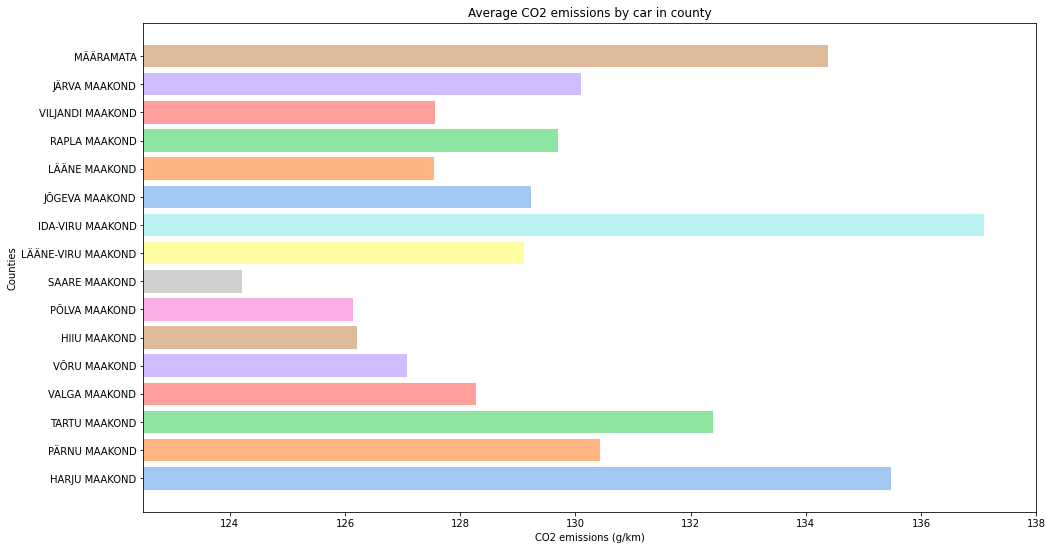

In [120]:
colors = sns.color_palette('pastel')[0:16]
fig, ax = plt.subplots(figsize =(16, 9))

ax.barh(MAAKONNAD, CO2_maakonniti, color=colors)

ax.set_xlabel('CO2 emissions (g/km)')
ax.set_ylabel('Counties')
ax.set_title('Average CO2 emissions by car in county')

plt.xlim([122.5,138])

plt.show()

In [35]:
margid={}
for i in range(len(data["Mark"])):
    mark=data["Mark"].iloc[i]
    if str(mark) not in margid:
        margid[str(mark)]=1  

In [36]:
#top 3 enim kasutatud auto mark
for i in range(len(data["Mark"])):
    mark=data["Mark"].iloc[i]
    margid[str(mark)]=margid.get(str(mark))+1
margid=dict(sorted(margid.items(), key=lambda item: item[1]))
print(list(margid.keys())[-1])
print(list(margid.keys())[-2])
print(list(margid.keys())[-3])

VOLKSWAGEN
TOYOTA
AUDI


In [37]:
mudelid_vw={}
mudelid_toyota={}
mudelid_audi={}

for i in range(len(data["Mudel"])):
    mark=data["Mark"].iloc[i]
    mudel=data["Mudel"].iloc[i]
    if str(mark) == "VOLKSWAGEN":
        if str(mudel) not in mudelid_vw:
            mudelid_vw[str(mudel)]=1
        else:
            mudelid_vw[str(mudel)]=mudelid_vw.get(str(mudel))+1
    elif str(mark) == "TOYOTA":
        if str(mudel) not in mudelid_toyota:
            mudelid_toyota[str(mudel)]=1
        else:
            mudelid_toyota[str(mudel)]=mudelid_toyota.get(str(mudel))+1
    elif str(mark) == "AUDI":
        if str(mudel) not in mudelid_audi:
            mudelid_audi[str(mudel)]=1
        else:
            mudelid_audi[str(mudel)]=mudelid_audi.get(str(mudel))+1

In [38]:
mudelid_audi=dict(sorted(mudelid_audi.items(), key=lambda item: item[1]))
mudelid_toyota=dict(sorted(mudelid_toyota.items(), key=lambda item: item[1]))
mudelid_vw=dict(sorted(mudelid_vw.items(), key=lambda item: item[1]))

print("AUDI TOP 3: ")
print(list(mudelid_audi.keys())[-1] + " " + str(list(mudelid_audi.values())[-1]))
print(list(mudelid_audi.keys())[-2] + " " + str(list(mudelid_audi.values())[-2]))
print(list(mudelid_audi.keys())[-3] + " " + str(list(mudelid_audi.values())[-3]))
print(list(mudelid_audi.keys())[-4] + " " + str(list(mudelid_audi.values())[-4]))
print()
print("Volkswagen TOP 3: ")
print(list(mudelid_vw.keys())[-1] + " " + str(list(mudelid_vw.values())[-1]))
print(list(mudelid_vw.keys())[-2] + " " + str(list(mudelid_vw.values())[-2]))
print(list(mudelid_vw.keys())[-3] + " " + str(list(mudelid_vw.values())[-3]))
print()
print("Toyota TOP 3: ")
print(list(mudelid_toyota.keys())[-1] + " " + str(list(mudelid_toyota.values())[-1]))
print(list(mudelid_toyota.keys())[-2] + " " + str(list(mudelid_toyota.values())[-2]))
print(list(mudelid_toyota.keys())[-3] + " " + str(list(mudelid_toyota.values())[-3]))

AUDI TOP 3: 
A6 AVANT 9395
A4 AVANT 7399
A4 4787
A6 4625

Volkswagen TOP 3: 
PASSAT 17205
GOLF 12801
PASSAT VARIANT 11543

Toyota TOP 3: 
AVENSIS 14439
COROLLA 11531
RAV4 11394


In [40]:
#Estonian motor sizes
mootori_maht = {}
mootori_mahud = []
mootoreid = []
data["MOOTORI_MAHT"] = data["MOOTORI_MAHT"].fillna(0)
for i in range(len(data["MOOTORI_MAHT"])):
    maht = data["MOOTORI_MAHT"].iloc[i]
    mahtr = round(int(maht)/1000,1)
    if str(mahtr) not in mootori_maht:
        mootori_maht[str(mahtr)] = 1
    else:
        mootori_maht[str(mahtr)]=mootori_maht.get(str(mahtr))+1
mootori_maht=dict(sorted(mootori_maht.items(), key=lambda item: item[1]))

In [41]:
for key, value in mootori_maht.items():
    if int(value) > 25000:
        mootori_mahud.append(key) 
        mootoreid.append(value)

In [42]:
res = {}
mootorcopy = mootoreid.copy()
for key in mootori_mahud:
    for value in mootorcopy:
        res[key] = value
        mootorcopy.remove(value)
        break
res=dict(sorted(res.items(), key=lambda item: item[1]))

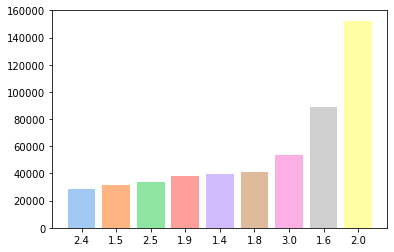

In [128]:
colors = sns.color_palette('pastel')[0:9]
plt.bar(*zip(*res.items()), color=colors)
#plt.title('Most popular engine sizes')
#plt.ylabel('Popularity')
#plt.xlabel('Engine size (l)')
plt.show()

In [44]:
kütused = {}
data["Kütusekombinatsioon"] = data["Kütusekombinatsioon"].fillna("TEADMATA")
for i in range(len(data["Kütusekombinatsioon"])):
    kütus = data["Kütusekombinatsioon"].iloc[i]
    if str(kütus) not in kütused:
        kütused[str(kütus)] = 1
    else:
        kütused[str(kütus)]=kütused.get(str(kütus))+1
kütused=dict(sorted(kütused.items(), key=lambda item: item[1]))
kütused = dict(reversed(list(kütused.items())))

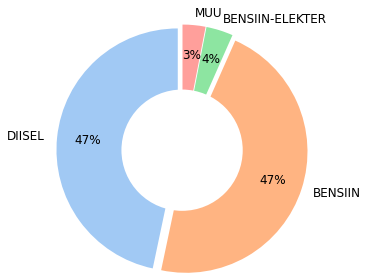

In [45]:
# Data to plot
labels = []
sizes = []

colors = sns.color_palette('pastel')[0:5]
muu_suurus=0
for x, y in kütused.items():
    if str(x)=="DIISEL" or str(x)=="BENSIIN" or str(x)=="BENSIIN-ELEKTER":
        labels.append(x)
        sizes.append(y)
    else:
        muu_suurus+=y

labels.append("MUU")
sizes.append(muu_suurus)

#explsion
explode = (0.05,0.05,0.05,0.05)
 
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.0f%%', startangle=90, pctdistance=0.75, explode = explode, radius=1.4, textprops={'fontsize': 12})
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
#ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [46]:
käigukastid = {}
data["KAIGUKASTI_TYYP"] = data["KAIGUKASTI_TYYP"].fillna("TEADMATA")
for i in range(len(data["KAIGUKASTI_TYYP"])):
    käigukast = data["KAIGUKASTI_TYYP"].iloc[i]
    if str(käigukast) not in käigukastid:
        käigukastid[str(käigukast)] = 1
    else:
        käigukastid[str(käigukast)]=käigukastid.get(str(käigukast))+1
käigukastid=dict(sorted(käigukastid.items(), key=lambda item: item[1]))
käigukastid = dict(reversed(list(käigukastid.items())))

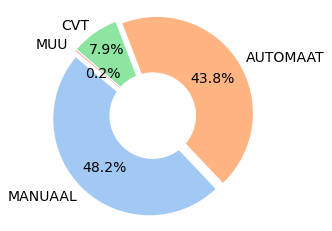

In [47]:
fig =plt.figure(figsize = (4,4))
ax11 = fig.add_subplot(111)
# Data to plot

labels = []
sizes = []

colors = sns.color_palette('pastel')[0:5]
muu_suurus=0
for x, y in käigukastid.items():
    if str(x)=="MANUAAL" or str(x)=="AUTOMAAT" or str(x)=="CVT":
        labels.append(x)
        sizes.append(y)
    else:
        muu_suurus+=y

labels.append("MUU")
sizes.append(muu_suurus)

explode = (0.05,0.05,0.05,0.05)

# Plot
w,l,p = ax11.pie(sizes,  labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=140, pctdistance=1, explode=explode,textprops={'fontsize': 14})

pctdists = [.7, .7, .8, .65]

for t,d in zip(p, pctdists):
    xi,yi = t.get_position()
    ri = np.sqrt(xi**2+yi**2)
    phi = np.arctan2(yi,xi)
    x = d*ri*np.cos(phi)
    y = d*ri*np.sin(phi)
    t.set_position((x,y))
    
centre_circle = plt.Circle((0,0),0.45,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.show()

In [48]:
aastad = {}
for i in range(len(data["ESMANE_REG_KP"])):
    aasta = int(str(data["ESMANE_REG_KP"].iloc[i])[6:10])
    if aasta not in aastad:
        aastad[aasta] = 1
    else:
        aastad[aasta]=aastad.get(aasta)+1

In [49]:
aastad=dict(sorted(aastad.items(), key=lambda item: item[1]))

aasta_vahemikud = ["1900-1989", "1990-1999", "2000-2005", "2006-2010", "2010-2015", "2016-2020", "2021+"]
autode_arv_vahemikus = [0,0,0,0,0,0,0]

for key, value in aastad.items():
    if key > 1899 and key < 1990:
        autode_arv_vahemikus[0] = autode_arv_vahemikus[0] + value
    elif key > 1899 and key < 2000:
        autode_arv_vahemikus[1] = autode_arv_vahemikus[1] + value
    elif key > 1999 and key < 2006:
        autode_arv_vahemikus[2] = autode_arv_vahemikus[2] + value
    elif key > 2005 and key < 2011:
        autode_arv_vahemikus[3] = autode_arv_vahemikus[3] + value
    elif key > 2010 and key < 2016:
        autode_arv_vahemikus[4] = autode_arv_vahemikus[4] + value
    elif key > 2015 and key < 2021:
        autode_arv_vahemikus[5] = autode_arv_vahemikus[5] + value
    else:
        autode_arv_vahemikus[6] = autode_arv_vahemikus[6] + value

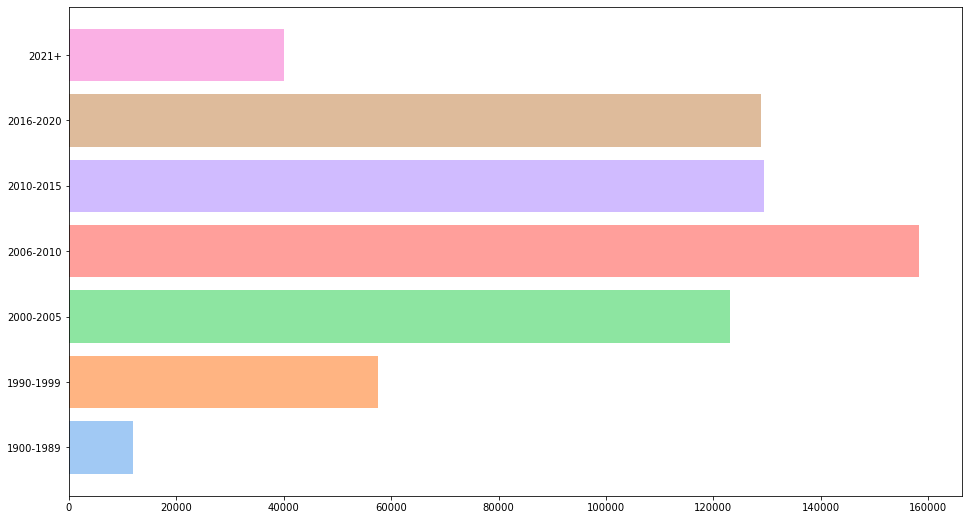

In [127]:
colors = sns.color_palette('pastel')[0:7]

fig, ax = plt.subplots(figsize =(16, 9))

ax.barh(aasta_vahemikud, autode_arv_vahemikus, color=colors)

#ax.set_xlabel('Number of cars')
#ax.set_ylabel('Years')
#ax.set_title('What manufacturing year are estonian cars')

plt.show()

In [51]:
võimsuse_vahemikud = ["0-50", "51-100", "101-150", "151-200", "201-250", "251+"]
autode_arv_võimsuse_vahemikus = [0,0,0,0,0,0]

for i in range(len(data["MOOTORI_VOIMSUS"])):
    võimsus_str = str(data["MOOTORI_VOIMSUS"].iloc[i])
    if ',' in võimsus_str:
        võimsus_str=võimsus_str.replace(",",".")
        data["MOOTORI_VOIMSUS"].iloc[i] = võimsus_str
        
    võimsus = float(võimsus_str)
    if võimsus <= 50:
        autode_arv_võimsuse_vahemikus[0] = autode_arv_võimsuse_vahemikus[0] + 1
    elif võimsus <= 100 and võimsus > 50:
        autode_arv_võimsuse_vahemikus[1] = autode_arv_võimsuse_vahemikus[1] + 1
    elif võimsus <= 150 and võimsus > 100:
        autode_arv_võimsuse_vahemikus[2] = autode_arv_võimsuse_vahemikus[2] + 1
    elif võimsus <= 200 and võimsus > 150:
        autode_arv_võimsuse_vahemikus[3] = autode_arv_võimsuse_vahemikus[3] + 1
    elif võimsus <= 250 and võimsus > 200:
        autode_arv_võimsuse_vahemikus[4] = autode_arv_võimsuse_vahemikus[4] + 1
    else:
        autode_arv_võimsuse_vahemikus[5] = autode_arv_võimsuse_vahemikus[5] + 1
        
data.head(100)

C:\Users\Liis Reimand\AppData\Local\Temp\ipykernel_15816\2250848960.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["MOOTORI_VOIMSUS"].iloc[i] = võimsus_str


,ESMANE_REG_KP,KAIGUKASTI_TYYP,MOOTORI_MAHT,MOOTORI_VOIMSUS,Kütusekombinatsioon,CO2_NEDC,Mark,Mudel,REG_MASS,HEITMENORM,VK/OM MAAKOND
0,18.05.2020,AUTOMAAT,1332.0,117,BENSIIN,131.0,NISSAN,QASHQAI,1885,EURO6,HARJU MAAKOND
1,01.01.1938,MANUAAL,2127.0,79,BENSIIN,NaN,VAUXHALL,-,1450,NaN,PÄRNU MAAKOND
2,01.01.1960,MANUAAL,2445.0,55,BENSIIN,NaN,GAZ,21I,1875,NaN,TARTU MAAKOND
3,01.01.1969,MANUAAL,1360.0,36,BENSIIN,NaN,AZLK,408,1290,NaN,VALGA MAAKOND
4,01.01.1974,MANUAAL,1450.0,55,BENSIIN,210.0,VAZ,2103,1430,NaN,VÕRU MAAKOND
...,...,...,...,...,...,...,...,...,...,...,...
95,02.01.1952,MANUAAL,2120.0,38,BENSIIN,NaN,GAZ,69A,1960,NaN,HARJU MAAKOND
96,01.01.1953,MANUAAL,1070.0,17,BENSIIN,NaN,MOSKVITŠ,401-420,1155,NaN,PÄRNU MAAKOND
97,01.01.1953,MANUAAL,1360.0,37,BENSIIN,NaN,MZMA,401,1155,NaN,RAPLA MAAKOND
98,01.01.1953,MANUAAL,1478.0,55,BENSIIN,NaN,MZMA,401,1155,NaN,VILJANDI MAAKOND


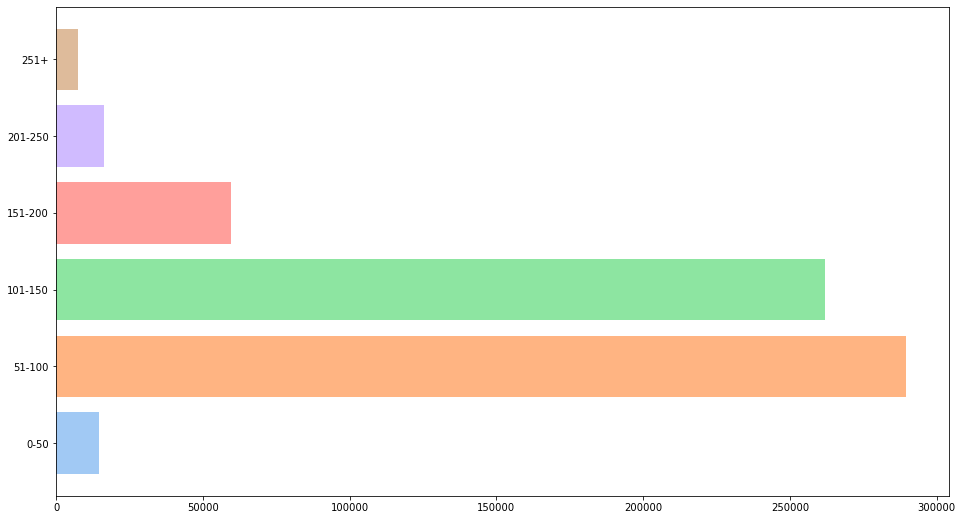

In [129]:
colors = sns.color_palette('pastel')[0:6]
fig, ax = plt.subplots(figsize =(16, 9))

ax.barh(võimsuse_vahemikud, autode_arv_võimsuse_vahemikus, color=colors)

#ax.set_xlabel('Autode arv')
#ax.set_ylabel('Võimsus')
#ax.set_title('Kui võimsad on Eesti rahva autod')

plt.show()

In [54]:
data.head()

,ESMANE_REG_KP,KAIGUKASTI_TYYP,MOOTORI_MAHT,MOOTORI_VOIMSUS,Kütusekombinatsioon,CO2_NEDC,Mark,Mudel,REG_MASS,HEITMENORM,VK/OM MAAKOND
0,18.05.2020,AUTOMAAT,1332.0,117,BENSIIN,131.0,NISSAN,QASHQAI,1885,EURO6,HARJU MAAKOND
1,01.01.1938,MANUAAL,2127.0,79,BENSIIN,NaN,VAUXHALL,-,1450,NaN,PÄRNU MAAKOND
2,01.01.1960,MANUAAL,2445.0,55,BENSIIN,NaN,GAZ,21I,1875,NaN,TARTU MAAKOND
3,01.01.1969,MANUAAL,1360.0,36,BENSIIN,NaN,AZLK,408,1290,NaN,VALGA MAAKOND
4,01.01.1974,MANUAAL,1450.0,55,BENSIIN,210.0,VAZ,2103,1430,NaN,VÕRU MAAKOND


In [55]:
big_predict=data.copy()

In [56]:
big_predict["AASTA"]=data["ESMANE_REG_KP"].str[-4:]
big_predict=big_predict.drop(["ESMANE_REG_KP","Mark","Mudel","VK/OM MAAKOND", "HEITMENORM"], axis=1)
big_predict=big_predict.dropna()

In [57]:
big_predict=big_predict.reset_index()
big_predict=big_predict.drop(["index"], axis=1)

In [58]:
vägaoluline=["BENSIIN-CNG-LPG","DIISEL-LPG","BENSIIN-LNG","ELEKTER-VESINIK","BENSIIN-CNG-ETANOOL","CNG-LPG","LPG","BENSIIN-ETANOOL-LPG","BENSIIN-ETANOOL","BENSIIN-ELEKTER-LPG", "BENSIIN-CNG","DIISEL-ELEKTER", "BENSIIN-LPG", "BENSIIN-ELEKTER"] 
for i in range(len(vägaoluline)):
    big_predict["Kütusekombinatsioon"]=big_predict["Kütusekombinatsioon"].replace([vägaoluline[i]],"MUU")

In [60]:
columns = big_predict.columns
big_predict = pd.get_dummies(big_predict, columns=['KAIGUKASTI_TYYP', "Kütusekombinatsioon"])

In [61]:
#train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#shuffle_data = big_predict.repeat().shuffle(5000).batch(batch_size).prefetch(1)
shuffle_data = big_predict.sample(frac = 1)
shuffle_data=shuffle_data.reset_index()
shuffle_data=shuffle_data.drop(["index"], axis=1)

In [62]:
shuffle_data.head()

,MOOTORI_MAHT,MOOTORI_VOIMSUS,CO2_NEDC,REG_MASS,AASTA,KAIGUKASTI_TYYP_AUTOMAAT,KAIGUKASTI_TYYP_AUTOMAT_MANUAAL,KAIGUKASTI_TYYP_CVT,KAIGUKASTI_TYYP_DCT,KAIGUKASTI_TYYP_KONSTANTNE_YLEKANNE,KAIGUKASTI_TYYP_MANUAAL,KAIGUKASTI_TYYP_MUU,Kütusekombinatsioon_BENSIIN,Kütusekombinatsioon_CNG,Kütusekombinatsioon_DIISEL,Kütusekombinatsioon_ELEKTER,Kütusekombinatsioon_MUU
0,1598.0,92,146.0,3020,2018,0,0,0,0,0,1,0,0,0,1,0,0
1,4663.0,320,269.0,3250,2014,1,0,0,0,0,0,0,1,0,0,0,0
2,1198.0,51,128.0,1570,2014,0,0,0,0,0,1,0,1,0,0,0,0
3,1198.0,47,142.0,1570,2006,0,0,0,0,0,1,0,1,0,0,0,0
4,1995.0,110,174.0,2085,2007,0,0,0,0,0,1,0,0,0,1,0,0


In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(shuffle_data.iloc[:, shuffle_data.columns!="CO2_NEDC"],shuffle_data["CO2_NEDC"], test_size=0.25, random_state=1)
X_train.shape

(404214, 16)

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()

In [65]:
#shuffle_data.to_csv("file.csv", encoding="utf-8")

In [66]:
#column_names = list(train_data.columns.values)
#column_names.remove("CO2_NEDC")
#x=np.array(train_data[column_names])
#y=np.array(train_data["CO2_NEDC"])
linear.fit(X_train,y_train)
y_pred = linear.predict(X_test)
df_preds = pd.DataFrame({"Actual":y_test.squeeze(), "pred":y_pred.squeeze()})
print(df_preds)
print(linear.score(X_train, y_train))
print(linear.score(X_test, y_test))
#print(s.intercept_)
#plt.scatter(X_train, y_train)
#plt.plot(X_train, s, color="red")
#plt.show
print(linear.coef_)

        Actual        pred
251327   104.0   94.736296
416604   105.0   99.693586
400343   246.0  229.543703
460280   184.0  179.475181
22545    162.0  183.382169
...        ...         ...
287012   148.0  148.759602
100658    96.0  103.788870
281899   171.0  198.300157
221532   157.0  159.516524
191106   106.0  123.625126

[134739 rows x 2 columns]
0.7810266449578794
0.7807021901830578
[ 3.06029991e-02 -5.64587864e-02  4.96736572e-02 -3.06282514e+00
  8.62866059e-01  1.57892986e+01 -1.05717373e+01  3.49963209e+01
 -9.69204644e+00 -5.71541655e+00 -2.56692852e+01  4.13690576e+01
  8.17657789e+00  6.12385686e+00 -6.26567107e+01  6.98721840e+00]


In [67]:
auto1 = linear.predict([[2000, 96, 1500, 2022, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])
print(auto1)

[87.60106313]


C:\Users\Liis Reimand\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [68]:
autosid = 0
automaate = 0
manuaale = 0
for i in range(len(data["ESMANE_REG_KP"])):
    aasta = int(str(data["ESMANE_REG_KP"].iloc[i])[-4:])
    if aasta >= 2022:
        if str(data["KAIGUKASTI_TYYP"].iloc[i]) == "MANUAAL":
            autosid += 1
            manuaale += 1
        elif str(data["KAIGUKASTI_TYYP"].iloc[i]) == "AUTOMAAT":
            autosid += 1
            automaate += 1
            
print(str((manuaale/autosid)*100) + " %")
print(str((automaate/autosid)*100) + " %")        

19.768253525059333 %
80.23174647494066 %


In [69]:
mootori_võimsused = []
for i in range(len(data["MOOTORI_VOIMSUS"])):
    võimsus_str = str(data["MOOTORI_VOIMSUS"].iloc[i])  
    võimsus = float(võimsus_str)
    aasta = int(str(data["ESMANE_REG_KP"].iloc[i])[-4:])
    if aasta >= 2010:
        mootori_võimsused.append(võimsus)

In [70]:
autod_bensiin = []
autod_diisel = []
aastad = [2025, 2030, 2035, 2040]
auto_võimsus = round(sum(mootori_võimsused)/len(mootori_võimsused))
print(auto_võimsus)
for i in range(len(aastad)):
    autod_diisel.append(linear.predict([[2000, auto_võimsus, 1500, aastad[i], 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])[0])
    autod_bensiin.append(linear.predict([[2000, auto_võimsus, 1500, aastad[i], 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])[0])
    
print(autod_diisel)
print(autod_bensiin)

118
[77.17049439517723, 61.85636867869562, 46.542242962214914, 31.22811724573421]
[112.41569510562658, 97.10156938914497, 81.78744367266427, 66.47331795618356]


C:\Users\Liis Reimand\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Liis Reimand\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Liis Reimand\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Liis Reimand\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Liis Reimand\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Liis Reimand\anaconda3\lib\site-packages\sklea

<Figure size 1440x1440 with 0 Axes>

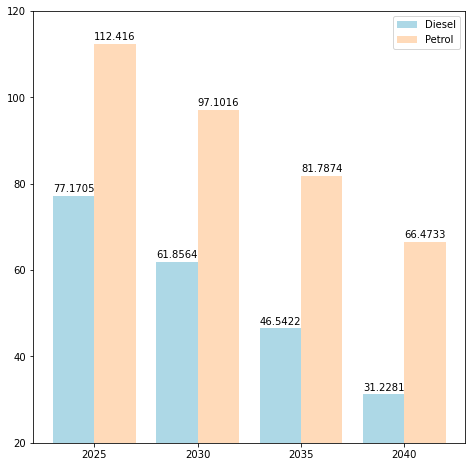

In [130]:
import matplotlib.pyplot as plt
import numpy as np

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)



plt.figure(figsize = (20,20))

x = np.arange(len(aastad))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, autod_diisel, width, label='Diesel', color="lightblue")
rects2 = ax.bar(x + width/2, autod_bensiin, width, label='Petrol', color="peachpuff")

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_ylabel('CO2 emissions')
#ax.set_title('Predicted CO2 emissions in future')
ax.set_xticks(x, aastad)
ax.legend()
set_size(6,6)
plt.ylim((20,120))
ax.bar_label(rects1, padding=2)
ax.bar_label(rects2, padding=2)

#fig.tight_layout()

plt.show()